In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### A **HUGE** diclamer here.
The data for Kaliningrad in this notebook is of different nature.  
We cannot be sure that the measurements were done correctly. The number of measurements is low and differs drastically from day to day.  
Also, we can't be sure if the measurements were done evenly during the 24 hours, or if they cover the entire 24 hours (maybe the data is only for the part of the day).  
So, the analysis coming below should be considered only as a fun exercise being done during diving into the air quality topic.  

In [2]:
data_dir = './data'
k25 = pd.read_csv(os.path.join(data_dir, 'kaliningrad-p2.5.csv'))
k10 = pd.read_csv(os.path.join(data_dir, 'kaliningrad-p10.csv'))
v = pd.read_csv(os.path.join(data_dir, 'europalaan,-veldhoven-air-quality.csv'))

In [3]:
# Drop statistically insignificant measurements
k25 = k25[k25['count'] > 144]  # hopefully once in 10 mins - 24 * 60 / 10 = 144
k10 = k10[k10['count'] > 144]

For Kaliningrad only concentration values are available.  
While for Veldhoven, only Air Quality Index (AQI) values are available.  
To compare the two cities we will calculate AQI for Kaliningrad.  

AQI is calculated in the [Air quality index -> Computing the AQI (Wikipedia)](https://en.wikipedia.org/wiki/Air_quality_index#Computing_the_AQI).  
To verify the correctness of the calculation the [AQI Calculator was used](https://www.airnow.gov/aqi/aqi-calculator-concentration/).

In [4]:
def concentration_to_aqi(x, pollutant):
    supported_pollutants = ['p25', 'p10']
    assert pollutant in supported_pollutants, f'Only two types of pollutants supported {supported_pollutants}, {pollutant} was given'
    breakpoints = {
        'p25': [(0.0, 12.0), (12.1,  35.4), ( 35.5,  55.4), ( 55.5, 150.4), (150.5, 205.4), (250.5, 350.4), (350.5, 500.4)],  
        'p10': [(0.0, 54.0), (55.0, 154.0), (155.0, 254.0), (255.0, 354.0), (355.0, 424.0), (425.0, 504.0), (505.0, 604.0)],
        'AQI': [(0.0, 50.0), (51.0, 100.0), (101.0, 150.0), (151.0, 200.0), (201.0, 300.0), (301.0, 400.0), (401.0, 500.0)]
    }
    
    def get_breakpoint_id(C, breakpoint_list):
        for i, C_vals in enumerate(breakpoint_list):
            C_low, C_high = C_vals
            if C < C_low:
                return i - 1
        if C > C_high:
            raise ValueError(f'Unexpectedly high value encountered for concentration: {C}')
        return i
    
    C = x
    i = get_breakpoint_id(C, breakpoints[pollutant])
    C_low, C_high = breakpoints[pollutant][i]
    I_low, I_high = breakpoints['AQI'][i]
    I = (I_high - I_low) / (C_high - C_low) * (C - C_low) + I_low
    return round(I)

In [5]:
k25['Kaliningrad-pm2.5-AQI'] = k25['median'].apply(concentration_to_aqi, args=('p25',))
k10['Kaliningrad-pm10-AQI'] = k10['median'].apply(concentration_to_aqi, args=('p10',))
v.rename(columns={' pm25': 'Veldhoven-pm2.5-AQI', ' pm10': 'Veldhoven-pm10-AQI'}, inplace=True)
k25.head()

,date,min,max,median,q1,q3,stdev,count,Kaliningrad-pm2.5-AQI
1,2021-10-21T00:00:00.000Z,0.80,8.00,1.67,1.30,4.17,2.078,319,7
2,2021-10-22T00:00:00.000Z,0.70,7.53,2.33,1.85,2.77,0.740,328,10
3,2021-10-23T00:00:00.000Z,0.60,8.43,2.17,1.70,2.80,0.938,442,9
4,2021-10-24T00:00:00.000Z,1.10,156.87,9.15,2.73,19.89,20.747,322,38
5,2021-10-25T00:00:00.000Z,4.23,28.87,11.33,6.70,15.80,5.068,326,47


In [6]:
def transform_date_k_to_iso(date):
    # input e.g. 2021-10-20T00:00:00.000Z
    return date.split('T')[0]

def transform_date_v_to_iso(date):
    # input e.g. 2023/5/1
    return '-'.join([f'{int(x):02}' for x in date.split('/')])

In [7]:
# Putting dfs in order
k25['date'] = k25['date'].apply(transform_date_k_to_iso)
k10['date'] = k10['date'].apply(transform_date_k_to_iso)
v['date'] = v['date'].apply(transform_date_v_to_iso)

In [8]:
# Merge dfs
k = pd.merge(left=k25, right=k10, on='date', how='inner')
df = pd.merge(left=v, right=k, on='date', how='inner')
# Keep only needed columns
columns_of_interest = ['date', 'Kaliningrad-pm2.5-AQI', 'Kaliningrad-pm10-AQI', 'Veldhoven-pm2.5-AQI', 'Veldhoven-pm10-AQI']
df = df.loc[:, columns_of_interest]
df.sort_values(by='date', inplace=True)
for col in columns_of_interest[1:]:
    df[col] = df[col].apply(lambda x: None if x == ' ' else int(x))
# Drop rows with missing data
df.dropna(inplace=True)
df.to_csv(os.path.join(data_dir, 'combined_data.csv'), index=False)

On the plots below the Kaliningrad data on the left side looks sane, but the behavior changes dramatically after late March.

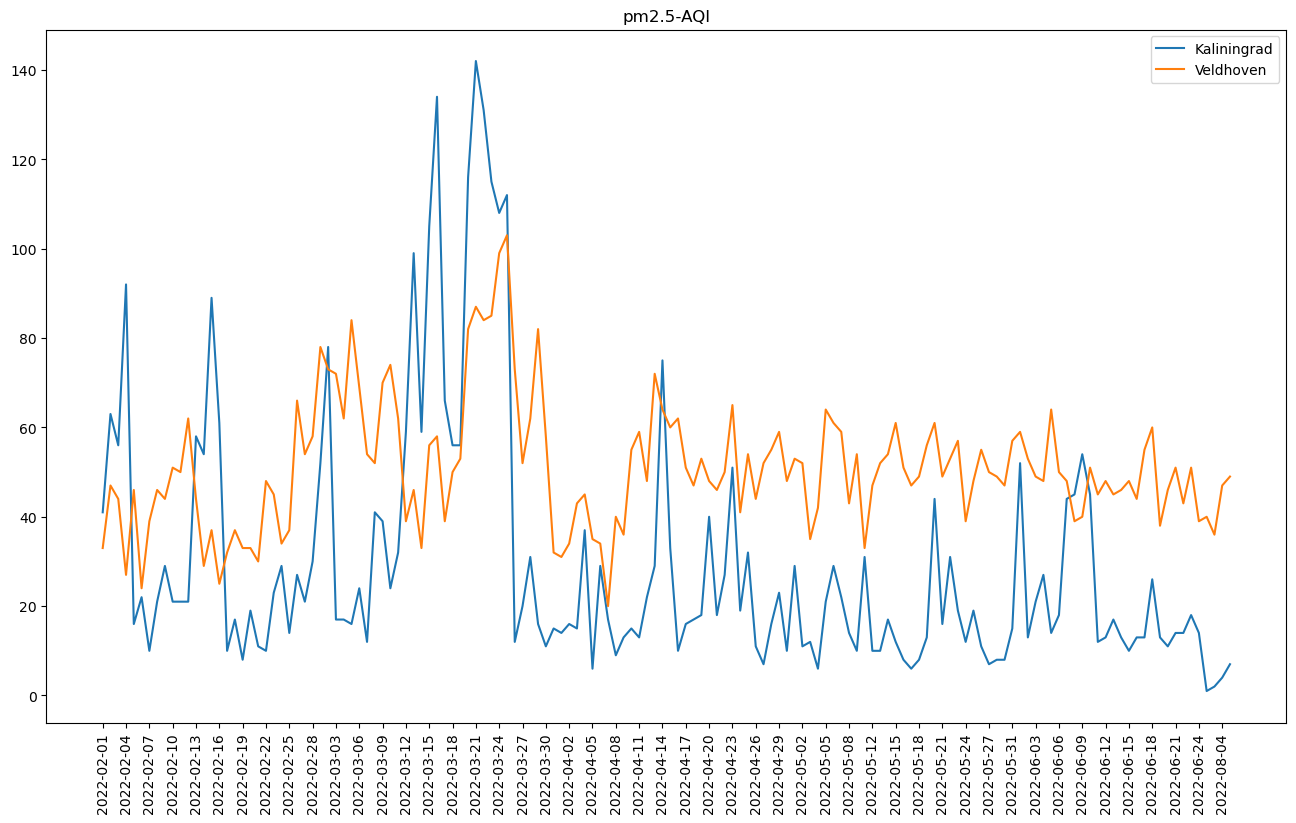

In [9]:
plt.figure(figsize=(16,9))
plt.title('pm2.5-AQI')
ticks = np.arange(len(df))
plt.plot(ticks, df['Kaliningrad-pm2.5-AQI'], label='Kaliningrad')
plt.plot(ticks, df['Veldhoven-pm2.5-AQI'], label='Veldhoven')
plt.xticks(ticks[::3], df['date'].values[::3], rotation=90)
plt.legend()
plt.show()

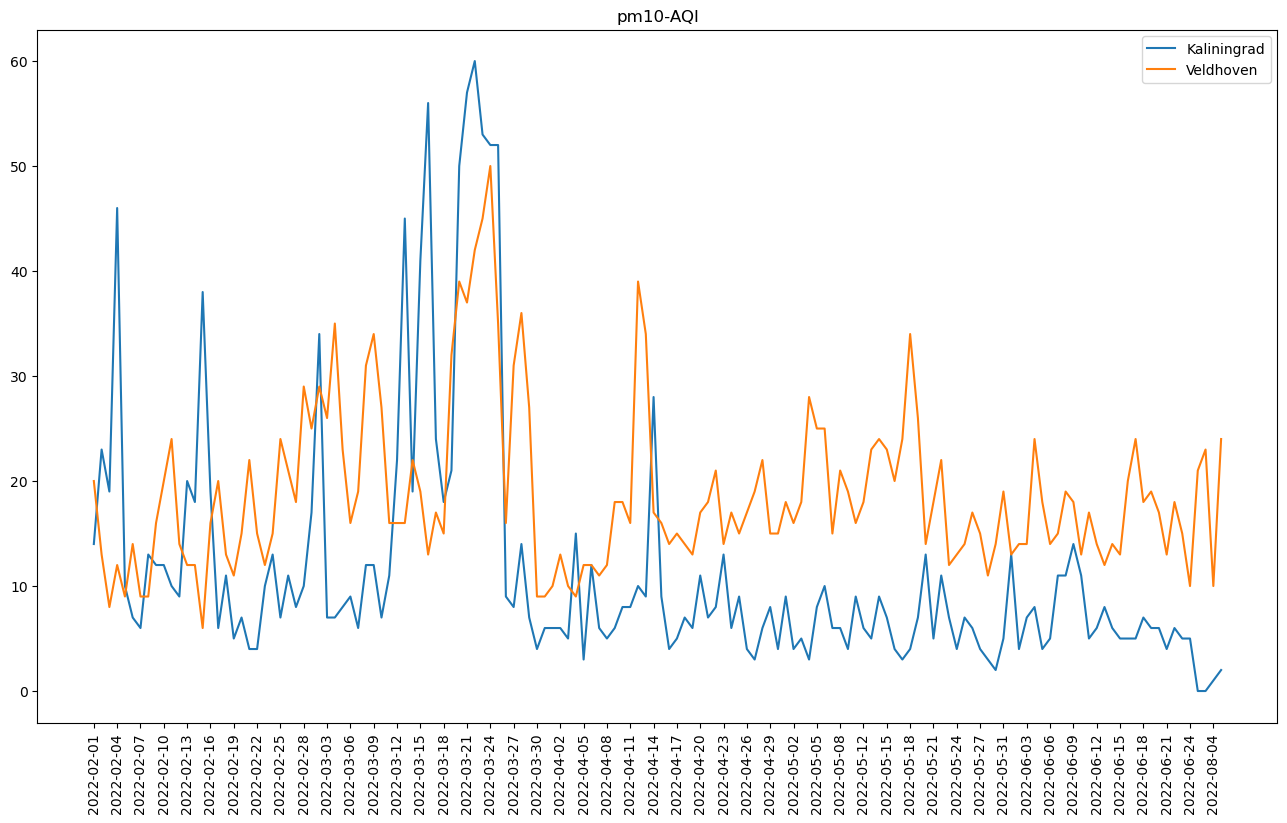

In [10]:
plt.figure(figsize=(16,9))
plt.title('pm10-AQI')
ticks = np.arange(len(df))
plt.plot(ticks, df['Kaliningrad-pm10-AQI'], label='Kaliningrad')
plt.plot(ticks, df['Veldhoven-pm10-AQI'], label='Veldhoven')
plt.xticks(ticks[::3], df['date'].values[::3], rotation=90)
plt.legend()
plt.show()

In [11]:
stats = dict()
stats['places'] = columns_of_interest[1:]
stats['min'] = list()
stats['max'] = list()
stats['mean'] = list()
stats['median'] = list()
for col in columns_of_interest[1:]:
    stats['min'].append(df[col].min())
    stats['max'].append(df[col].max())
    stats['mean'].append(df[col].mean())
    stats['median'].append(df[col].median())
stats = pd.DataFrame(stats)

In [12]:
stats.head()

,places,min,max,mean,median
0,Kaliningrad-pm2.5-AQI,1.0,142.0,29.958904,18.0
1,Kaliningrad-pm10-AQI,0.0,60.0,11.664384,7.0
2,Veldhoven-pm2.5-AQI,20.0,103.0,50.952055,49.0
3,Veldhoven-pm10-AQI,6.0,50.0,18.869863,17.0
